<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S12/S12_AssignmentSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


**Append Library Path**

In [2]:
import sys
sys.path.append("/content/drive/My Drive/mylib/evaLibrary")
!ls '/content/drive/My Drive/mylib/evaLibrary'

AlbTestTransforms.py   cyclicLR.py     K-MeansClusteringCalculation.xlsx
AlbTrainTransforms.py  DataLoaders.py  LR_Finder.py
AlbTransforms.py       DataPrep.py     __pycache__
albumentations.py      displayData.py  resNet.py
all.py		       execute.py      rohan_library.py
customNet.py	       Gradcam.py      TinyImageNetDataset.py


**Load required Libraries**

In [3]:
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import DataLoaders as loader
import AlbTransforms as alb
import LR_Finder as lrf
import cyclicLR as clr
import DataPrep as dp

  pip install torch-lr-finder -v --global-option="amp"


**Download TinyImageNet Zip File**

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

In [7]:
import albumentations as A
import cv2
channel_means = (0.442,0.442,0.442)
channel_stdevs = (0.278, 0.278, 0.278)
train_transform = alb.AlbumentationTransforms([  
                                        A.PadIfNeeded(min_height=70, min_width=70, border_mode=4,  p=1.0),
                                        A.RandomCrop(64, 64,  p=1.0),     
                                        A.Flip(p=0.5),
                                        A.Cutout(num_holes = 2, max_h_size = 8, max_w_size = 8, p = 1.0),
                                        A.Normalize(mean=channel_means, std=channel_stdevs)   
                                       ])
test_transform = alb.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
train_dataset , test_dataset,classes = dp.TinyImageNetDataSet(splitRatio = 70,test_transforms = test_transform,train_transforms = train_transform)


110000


#Load the datasets to Dataloaders

In [8]:
trainLoader, testLoader = loader.Data_To_Dataloader(train_dataset,test_dataset,batch_size=128)

**ImageNet Classes & ClassID**

In [50]:
ID = dp.xtractClassID(path = "/content/tiny-imagenet-200/wnids.txt")
className = dp.xtractClassNames("/content/tiny-imagenet-200/words.txt", ID)


classes = list(className.values())
classes

/content/tiny-imagenet-200/wnids.txt


['goldfish, Carassius auratus',
 'European fire salamander, Salamandra salamandra',
 'bullfrog, Rana catesbeiana',
 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'American alligator, Alligator mississipiensis',
 'boa constrictor, Constrictor constrictor',
 'trilobite',
 'scorpion',
 'black widow, Latrodectus mactans',
 'tarantula',
 'centipede',
 'goose',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'jellyfish',
 'brain coral',
 'snail',
 'slug',
 'sea slug, nudibranch',
 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'black stork, Ciconia nigra',
 'king penguin, Aptenodytes patagonica',
 'albatross, mollymawk',
 'dugong, Dugong dugon',
 'Chihuahua',
 'Yorkshire terrier',
 'golden retriever',
 'Labrador retriever',
 'German shepherd, German shepherd dog, German police dog, alsatian',
 'standard poodle',
 'tabby, tabby cat',
 'Persia

#ResNet18 Model Summary

In [10]:
from torchsummary import summary
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

# LR Finder Test

In [11]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2)

lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader,start_lr=1e-5, end_lr=10, num_iter=5*len(trainLoader), step_mode='exp')

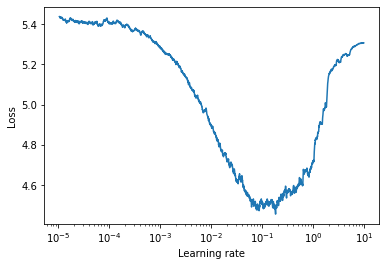

In [12]:
lr_finder.plot()

In [14]:
lr_finder.reset()

#Training & Testing ResNet18 on TinyImageNet

In [15]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = ResNet18().to(device)
EPOCHS = 50
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, total_steps=31000, epochs = 50, steps_per_epoch=len(trainLoader),
                                                pct_start=0.5, anneal_strategy='linear', cycle_momentum=True, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=10, final_div_factor=1)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, threshold=0.001)

model1 = execute.Test_Train(model, device, optimizer, criterion, scheduler=True)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch)
  scheduler.step()
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  # scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])
  

  0%|          | 0/602 [00:00<?, ?it/s]

EPOCH:  1


Loss=4.076071739196777 Batch_id=601 Accuracy=6.21: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 4.3080).  Saving model ...

Test set: Average loss: 4.3080, Accuracy: 3453/33000 (10.46%)

Learning Rate = 0.001 for EPOCH 2
EPOCH:  2


Loss=3.8937480449676514 Batch_id=601 Accuracy=14.21: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (4.3080 --> 4.1089).  Saving model ...

Test set: Average loss: 4.1089, Accuracy: 5249/33000 (15.91%)

Learning Rate = 0.001 for EPOCH 3
EPOCH:  3


Loss=3.828000068664551 Batch_id=601 Accuracy=19.05: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (4.1089 --> 3.8086).  Saving model ...

Test set: Average loss: 3.8086, Accuracy: 6265/33000 (18.98%)

Learning Rate = 0.001 for EPOCH 4
EPOCH:  4


Loss=3.144444465637207 Batch_id=601 Accuracy=23.09: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.8086 --> 3.7739).  Saving model ...

Test set: Average loss: 3.7739, Accuracy: 7137/33000 (21.63%)

Learning Rate = 0.001 for EPOCH 5
EPOCH:  5


Loss=3.5240068435668945 Batch_id=601 Accuracy=26.44: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.7739 --> 3.4725).  Saving model ...

Test set: Average loss: 3.4725, Accuracy: 8555/33000 (25.92%)

Learning Rate = 0.001 for EPOCH 6
EPOCH:  6


Loss=3.1454131603240967 Batch_id=601 Accuracy=29.57: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.4725 --> 3.1984).  Saving model ...

Test set: Average loss: 3.1984, Accuracy: 8815/33000 (26.71%)

Learning Rate = 0.001 for EPOCH 7
EPOCH:  7


Loss=2.8016085624694824 Batch_id=601 Accuracy=32.10: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.1984 --> 2.6661).  Saving model ...

Test set: Average loss: 2.6661, Accuracy: 10166/33000 (30.81%)

Learning Rate = 0.001 for EPOCH 8
EPOCH:  8


Loss=3.209289073944092 Batch_id=601 Accuracy=34.56: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.6661 --> 2.5345).  Saving model ...

Test set: Average loss: 2.5345, Accuracy: 10975/33000 (33.26%)

Learning Rate = 0.001 for EPOCH 9
EPOCH:  9


Loss=2.80472731590271 Batch_id=601 Accuracy=36.62: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7288, Accuracy: 11461/33000 (34.73%)

Learning Rate = 0.00101 for EPOCH 10
EPOCH:  10


Loss=2.668422222137451 Batch_id=601 Accuracy=38.68: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.5345 --> 2.4824).  Saving model ...

Test set: Average loss: 2.4824, Accuracy: 12363/33000 (37.46%)

Learning Rate = 0.00101 for EPOCH 11
EPOCH:  11


Loss=2.529733419418335 Batch_id=601 Accuracy=40.12: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7215, Accuracy: 12140/33000 (36.79%)

Learning Rate = 0.00101 for EPOCH 12
EPOCH:  12


Loss=2.6204147338867188 Batch_id=601 Accuracy=41.79: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5460, Accuracy: 12210/33000 (37.00%)

Learning Rate = 0.00101 for EPOCH 13
EPOCH:  13


Loss=2.2871320247650146 Batch_id=601 Accuracy=43.36: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.4824 --> 2.3569).  Saving model ...

Test set: Average loss: 2.3569, Accuracy: 12724/33000 (38.56%)

Learning Rate = 0.00101 for EPOCH 14
EPOCH:  14


Loss=2.214676856994629 Batch_id=601 Accuracy=44.71: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.3569 --> 2.3301).  Saving model ...

Test set: Average loss: 2.3301, Accuracy: 13298/33000 (40.30%)

Learning Rate = 0.00101 for EPOCH 15
EPOCH:  15


Loss=1.920623540878296 Batch_id=601 Accuracy=46.00: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.9047, Accuracy: 13057/33000 (39.57%)

Learning Rate = 0.00101 for EPOCH 16
EPOCH:  16


Loss=2.1348819732666016 Batch_id=601 Accuracy=47.78: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3474, Accuracy: 13644/33000 (41.35%)

Learning Rate = 0.00101 for EPOCH 17
EPOCH:  17


Loss=2.1786882877349854 Batch_id=601 Accuracy=48.74: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4403, Accuracy: 14325/33000 (43.41%)

Learning Rate = 0.00101 for EPOCH 18
EPOCH:  18


Loss=1.9279725551605225 Batch_id=601 Accuracy=50.06: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.3301 --> 2.0618).  Saving model ...

Test set: Average loss: 2.0618, Accuracy: 14416/33000 (43.68%)

Learning Rate = 0.00101 for EPOCH 19
EPOCH:  19


Loss=1.768085241317749 Batch_id=601 Accuracy=51.09: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5453, Accuracy: 14278/33000 (43.27%)

Learning Rate = 0.00101 for EPOCH 20
EPOCH:  20


Loss=1.941100835800171 Batch_id=601 Accuracy=52.20: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3013, Accuracy: 14754/33000 (44.71%)

Learning Rate = 0.00101 for EPOCH 21
EPOCH:  21


Loss=1.625564455986023 Batch_id=601 Accuracy=53.32: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3559, Accuracy: 14783/33000 (44.80%)

Learning Rate = 0.00101 for EPOCH 22
EPOCH:  22


Loss=1.622874140739441 Batch_id=601 Accuracy=54.40: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1903, Accuracy: 14775/33000 (44.77%)

Learning Rate = 0.00101 for EPOCH 23
EPOCH:  23


Loss=1.719130039215088 Batch_id=601 Accuracy=55.52: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4179, Accuracy: 15081/33000 (45.70%)

Learning Rate = 0.00101 for EPOCH 24
EPOCH:  24


Loss=1.9302902221679688 Batch_id=601 Accuracy=56.49: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.0618 --> 1.7596).  Saving model ...

Test set: Average loss: 1.7596, Accuracy: 15454/33000 (46.83%)

Learning Rate = 0.00101 for EPOCH 25
EPOCH:  25


Loss=1.404343843460083 Batch_id=601 Accuracy=57.65: 100%|██████████| 602/602 [02:27<00:00,  4.09it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.0816, Accuracy: 15307/33000 (46.38%)

Learning Rate = 0.00101 for EPOCH 26
EPOCH:  26


Loss=1.6224373579025269 Batch_id=601 Accuracy=58.42: 100%|██████████| 602/602 [02:27<00:00,  4.09it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9852, Accuracy: 15673/33000 (47.49%)

Learning Rate = 0.00102 for EPOCH 27
EPOCH:  27


Loss=1.5013972520828247 Batch_id=601 Accuracy=59.28: 100%|██████████| 602/602 [02:27<00:00,  4.09it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2201, Accuracy: 15664/33000 (47.47%)

Learning Rate = 0.00102 for EPOCH 28
EPOCH:  28


Loss=1.9879908561706543 Batch_id=601 Accuracy=60.36: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2350, Accuracy: 15527/33000 (47.05%)

Learning Rate = 0.00102 for EPOCH 29
EPOCH:  29


Loss=1.1903787851333618 Batch_id=601 Accuracy=61.41: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1799, Accuracy: 15900/33000 (48.18%)

Learning Rate = 0.00102 for EPOCH 30
EPOCH:  30


Loss=1.4343317747116089 Batch_id=601 Accuracy=62.11: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1319, Accuracy: 16061/33000 (48.67%)

Learning Rate = 0.00102 for EPOCH 31
EPOCH:  31


Loss=1.619841456413269 Batch_id=601 Accuracy=63.11: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.0620, Accuracy: 16097/33000 (48.78%)

Learning Rate = 0.00102 for EPOCH 32
EPOCH:  32


Loss=1.6069118976593018 Batch_id=601 Accuracy=63.98: 100%|██████████| 602/602 [02:27<00:00,  4.09it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5160, Accuracy: 16041/33000 (48.61%)

Learning Rate = 0.00102 for EPOCH 33
EPOCH:  33


Loss=1.3100991249084473 Batch_id=601 Accuracy=65.07: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1725, Accuracy: 15816/33000 (47.93%)

Learning Rate = 0.00102 for EPOCH 34
EPOCH:  34


Loss=1.5558497905731201 Batch_id=601 Accuracy=65.52: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9991, Accuracy: 16505/33000 (50.02%)

Learning Rate = 0.00102 for EPOCH 35
EPOCH:  35


Loss=1.531965732574463 Batch_id=601 Accuracy=66.76: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2725, Accuracy: 16310/33000 (49.42%)

Learning Rate = 0.00102 for EPOCH 36
EPOCH:  36


Loss=1.264199137687683 Batch_id=601 Accuracy=67.60: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9821, Accuracy: 16258/33000 (49.27%)

Learning Rate = 0.00102 for EPOCH 37
EPOCH:  37


Loss=1.3316304683685303 Batch_id=601 Accuracy=68.44: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3433, Accuracy: 16186/33000 (49.05%)

Learning Rate = 0.00102 for EPOCH 38
EPOCH:  38


Loss=1.2843443155288696 Batch_id=601 Accuracy=69.50: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4058, Accuracy: 16437/33000 (49.81%)

Learning Rate = 0.00102 for EPOCH 39
EPOCH:  39


Loss=1.0528720617294312 Batch_id=601 Accuracy=69.74: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1227, Accuracy: 16614/33000 (50.35%)

Learning Rate = 0.00102 for EPOCH 40
EPOCH:  40


Loss=0.7768110632896423 Batch_id=601 Accuracy=71.01: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1703, Accuracy: 16538/33000 (50.12%)

Learning Rate = 0.00102 for EPOCH 41
EPOCH:  41


Loss=1.0415573120117188 Batch_id=601 Accuracy=71.82: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (1.7596 --> 1.7402).  Saving model ...

Test set: Average loss: 1.7402, Accuracy: 16510/33000 (50.03%)

Learning Rate = 0.00102 for EPOCH 42
EPOCH:  42


Loss=1.117508888244629 Batch_id=601 Accuracy=72.49: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.8586, Accuracy: 16517/33000 (50.05%)

Learning Rate = 0.00102 for EPOCH 43
EPOCH:  43


Loss=1.222959280014038 Batch_id=601 Accuracy=73.25: 100%|██████████| 602/602 [02:26<00:00,  4.11it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1044, Accuracy: 16226/33000 (49.17%)

Learning Rate = 0.00102 for EPOCH 44
EPOCH:  44


Loss=1.1644577980041504 Batch_id=601 Accuracy=74.44: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5121, Accuracy: 16743/33000 (50.74%)

Learning Rate = 0.00103 for EPOCH 45
EPOCH:  45


Loss=0.9761316776275635 Batch_id=601 Accuracy=75.03: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1288, Accuracy: 16609/33000 (50.33%)

Learning Rate = 0.00103 for EPOCH 46
EPOCH:  46


Loss=1.0170502662658691 Batch_id=601 Accuracy=76.19: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3760, Accuracy: 16649/33000 (50.45%)

Learning Rate = 0.00103 for EPOCH 47
EPOCH:  47


Loss=0.7487260103225708 Batch_id=601 Accuracy=76.76: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3905, Accuracy: 16610/33000 (50.33%)

Learning Rate = 0.00103 for EPOCH 48
EPOCH:  48


Loss=0.9588489532470703 Batch_id=601 Accuracy=77.13: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.7455, Accuracy: 16894/33000 (51.19%)

Learning Rate = 0.00103 for EPOCH 49
EPOCH:  49


Loss=1.0270007848739624 Batch_id=601 Accuracy=78.54: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1559, Accuracy: 16494/33000 (49.98%)

Learning Rate = 0.00103 for EPOCH 50
EPOCH:  50


Loss=1.0631338357925415 Batch_id=601 Accuracy=79.11: 100%|██████████| 602/602 [02:26<00:00,  4.10it/s]



Test set: Average loss: 2.1071, Accuracy: 16545/33000 (50.14%)

Learning Rate = 0.00103 for EPOCH 51


In [16]:
# a = []
# while(1):
#   a.append("b")

**Displaying Model Curves**

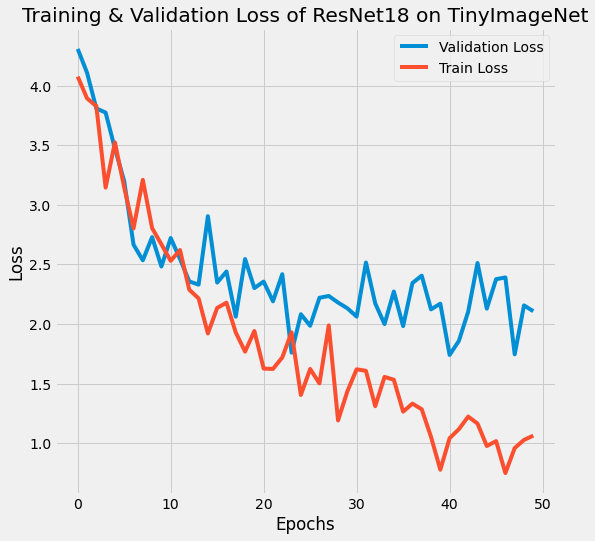

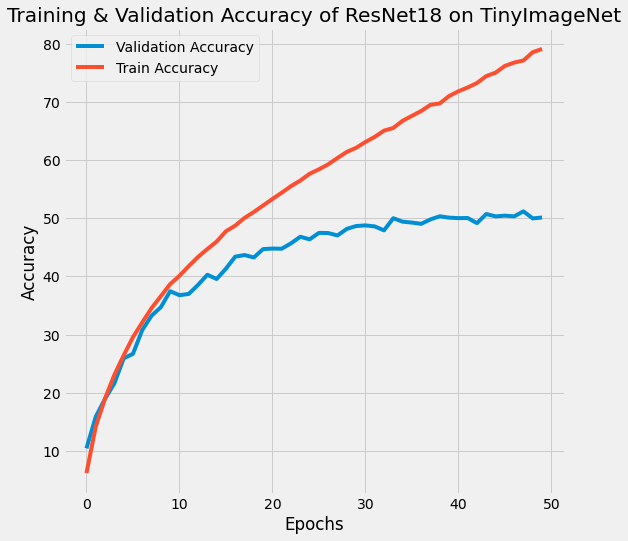

In [17]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on TinyImageNet', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on TinyImageNet')

In [ ]:
import matplotlib.pyplot as plt
with plt.style.context('fivethirtyeight'):
  plt.plot(learningRates, '-D')
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Learning Rate', fontsize=12)
  plt.title('Learning Rate over Training-Epochs',fontsize=15)

#Misclassified Images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1080x1080 with 0 Axes>

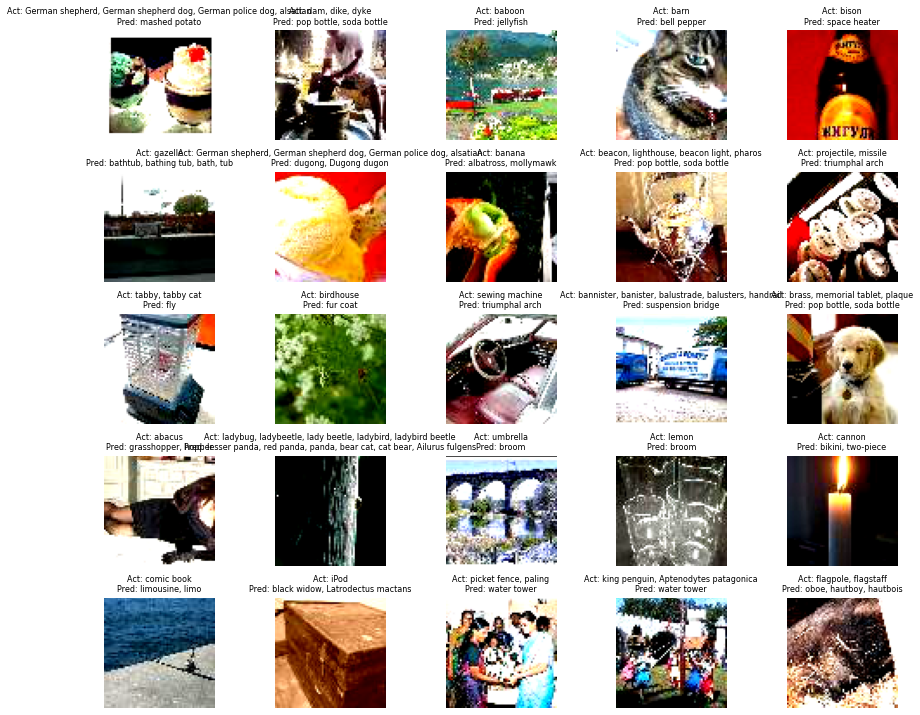

In [46]:
# 25 Misclassified Images 
display.misclassified_ones(model1, testLoader, incorrectSamples, 'misclassifiedOnes.png', list(className.values()))

#GradCam for Misclassified Images

torch.Size([8, 200])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


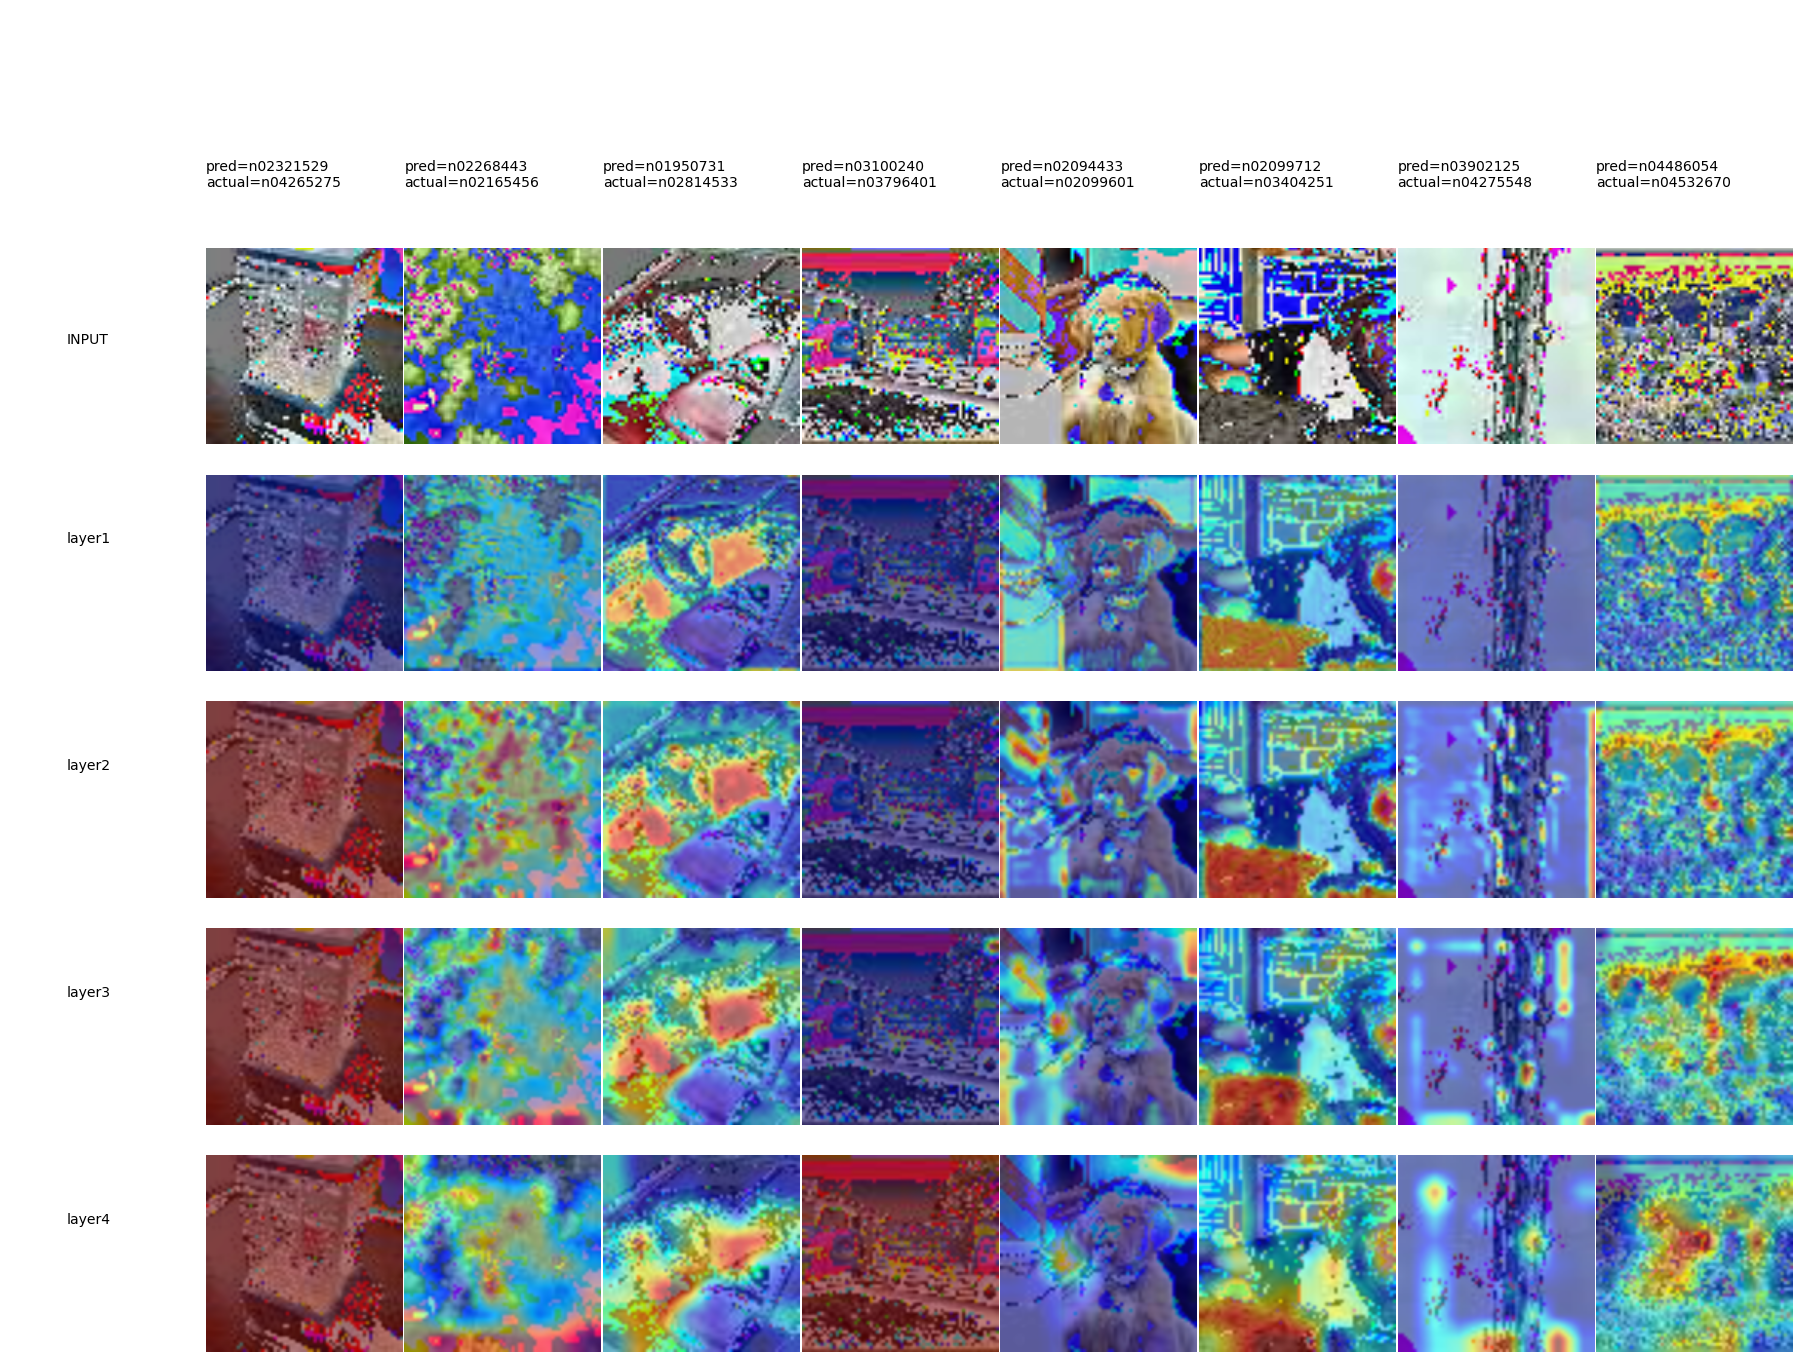

In [58]:
images = [x['image'] for x in incorrectSamples[10:18]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:18]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:18]] # Predicted Classes

targetLabels = [ID[t] for t in target_classes] # Target ID
predLabels = [ID[p] for p in predicted_classes] # Predicted ID



model = ResNet18().to(device)
image_size = (3,64,64) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gdc.GRADCAM(images, device, target_classes, model, target_layers) 

gdc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers